In [211]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
import xgboost

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [212]:
df = pd.read_csv("winequality-white.csv", sep = ";")
print(df.isnull().head()) # check for missing values

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          False             False        False           False      False   
1          False             False        False           False      False   
2          False             False        False           False      False   
3          False             False        False           False      False   
4          False             False        False           False      False   

   free sulfur dioxide  total sulfur dioxide  density     pH  sulphates  \
0                False                 False    False  False      False   
1                False                 False    False  False      False   
2                False                 False    False  False      False   
3                False                 False    False  False      False   
4                False                 False    False  False      False   

   alcohol  quality  
0    False    False  
1    False    False  
2    False    

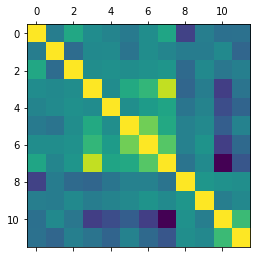

In [213]:
# correlation matrix
plt.matshow(df.corr())
plt.show()

In [214]:
# dropping residual.sugar, density, and total.sulfur.dioxide
df.drop(["residual sugar", "density", "total sulfur dioxide"], axis = 1, inplace = True)

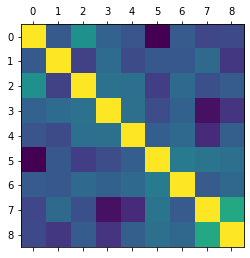

In [215]:
# new correlation matrix
plt.matshow(df.corr())
plt.show()

In [216]:
from sklearn import preprocessing
X = df.loc[:, 'fixed acidity':'alcohol']
X_std = preprocessing.scale(X)

In [217]:
# converting from numeric to categorical
def score_to_label(x):
    if x > 5:
        return "good"
    else:
        return "bad"

In [218]:
df['label'] = df['quality'].apply(score_to_label) # converting quality to label
df.drop(['quality'], axis = 1, inplace = True)

df.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,pH,sulphates,alcohol,label
0,7.0,0.27,0.36,0.045,45.0,3.00,0.45,8.8,good
1,6.3,0.30,0.34,0.049,14.0,3.30,0.49,9.5,good
2,8.1,0.28,0.40,0.050,30.0,3.26,0.44,10.1,good
3,7.2,0.23,0.32,0.058,47.0,3.19,0.40,9.9,good
4,7.2,0.23,0.32,0.058,47.0,3.19,0.40,9.9,good


In [219]:
df.label, class_names = pd.factorize(df.label)

In [220]:
# creating a matrix for records
# numpy is loaded
# pandas is loaded
records = np.zeros(shape=(6,3))
column_names = ['Accuracy.Rate', 'Error.Rate', 'AUC']
records = pd.DataFrame(records, columns = column_names)

In [221]:
# split the data intro training and test sets, test size is 30% of the data
from sklearn.model_selection import train_test_split
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [222]:
from sklearn.tree import DecisionTreeClassifier

# model fitting
# decision tree classifier object
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100)
# training the model 
clf_gini.fit(X_train, y_train)

# predicting
y_pred = clf_gini.predict(X_test)

In [246]:
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.773469387755102
[[831 179]
 [154 306]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1010
           1       0.63      0.67      0.65       460

    accuracy                           0.77      1470
   macro avg       0.74      0.74      0.74      1470
weighted avg       0.78      0.77      0.78      1470



In [225]:
"""
visualization of decision tree
 import graphviz
feature_names = X.columns
dot_data = tree.export_graphviz(clf_gini, out_file=None, filled=True, rounded=True,
                                feature_names=feature_names,  
                                class_names=class_names)
graph = graphviz.Source(dot_data)  
graph
"""

'\nvisualization of decision tree\n import graphviz\nfeature_names = X.columns\ndot_data = tree.export_graphviz(clf_gini, out_file=None, filled=True, rounded=True,\n                                feature_names=feature_names,  \n                                class_names=class_names)\ngraph = graphviz.Source(dot_data)  \ngraph\n'

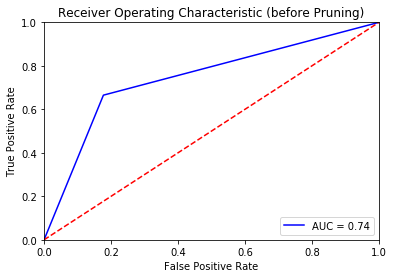

In [226]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_gini.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic (before Pruning)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [227]:
# k-fold cross validation
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits = 10, shuffle = True, random_state = 100)
cv_results = cross_val_score(estimator = clf_gini, X = X, y = y, cv = kf, scoring = "accuracy", n_jobs = -1)

print("mean: {:.3f} (std: {:.3f})".format(cv_results.mean(),
                                          cv_results.std()),
                                          end="\n\n" )

mean: 0.797 (std: 0.022)



In [247]:
# k-nearest neighbors
from sklearn import neighbors

clf_knn = neighbors.KNeighborsClassifier(10, weights = "distance")
clf_knn.fit(X_train, y_train)

clf_knn.predict(X_test)

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

0.8561192423590185


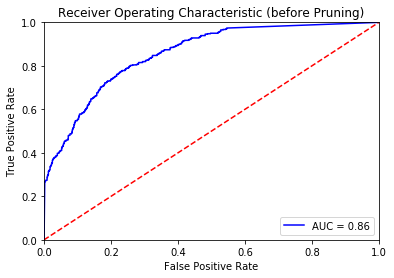

In [235]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_knn.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


print(roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic (before Pruning)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [244]:
# initialize dataFrame to store accuracy rates and AUC for different values of k

knn_df = pd.DataFrame(index = range(1,51), columns = ['k', 'AccuracyRate', 'AUC'])
knn_df = knn_df.fillna(0)
knn_df.k = range(1,51)

In [254]:
for k in range(1,50):
    # Fit the kNN classifier
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights = "distance") # creating the classifier
    clf_knn.fit(X_train, y_train)
    knn_pred = clf_knn.predict(X_test) # predicting with the test set
    
    # Calculate AUC
    probs = clf_knn.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    # Fill the DataFrame with metrics
    knn_df.AccuracyRate.iloc[[k]] = metrics.accuracy_score(y_test, knn_pred)
    knn_df.AUC.iloc[[k]] = roc_auc

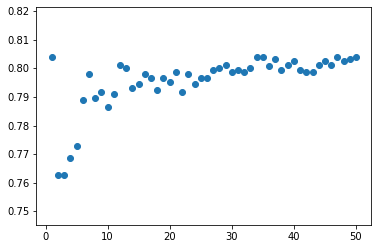

In [258]:
plt.scatter(knn_df['k'], knn_df['AccuracyRate'])
plt.show()

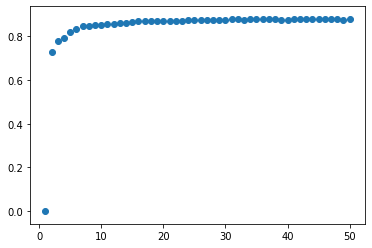

In [259]:
plt.scatter(knn_df['k'], knn_df['AUC'])
plt.show()